# Optical Data Reduction using Python 

by Steve Crawford (South African Astronomical Observatory)

In [166]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In addition to instrument specific python pipelines, there now exists a suite of tools available for general reduction of optical observations. This includes  *ccdproc*, an astropy affiliated package for basic CCD reductions. The package is useful from student tutorials for learning CCD reductions to building science-quality reduction pipelines for observatories. In addition, we also present specreduce, a python package for reducing optical spectroscopy. The package includes an interactive graphical users interface for line identification as well as tools for extracting spectra. With this set of tools, pipelines can be built for instruments in relatively short times. While nearly complete, further improvements and enhancements are still needed and contributions are welcome.

# Introduction

For our purposes, we will use the [same data](http://iraf.noao.edu/iraf/ftp/iraf/misc/) in the [IRAF tutorials](http://iraf.noao.edu/tutorials/).   However, we will show how to reduce the data in the same way only using current general purpose python tools.  


In [2]:
import numpy as np
from matplotlib import pyplot as plt

from astropy import units as u
from astropy.io import fits
from astropy import modeling as mod

## CCD Reduction

In [3]:
import ccdproc 
from ccdproc import CCDData, ImageFileCollection

[*ccdproc*](https://github.com/astropy/ccdproc) is an astropy affiliated package for handling CCD data reductions.   The code contains all the necessary content to produce pipelines for basic CCD reductions.   Here we use *ccdproc* to reduce a spectroscopic data set.


The *ImageFileCollection* class in *ccdproc* is useful for reading and sorting of the FITS files in a directory.   

In [4]:
from ccdproc import ImageFileCollection
image_dir = 'exercises/spec/'
ic = ImageFileCollection('exercises/spec/') #read in all FITS files in the directory

In [5]:
ic.summary

file,simple,bitpix,naxis,naxis1,naxis2,extend,origin,date,iraf-tlm,datamin,datamax,object,iraf-max,iraf-min,observat,observer,exptime,darktime,imagetyp,date-obs,ut,st,ra,dec,epoch,zd,airmass,telescop,detector,preflash,gain,dwell,rdnoise,delay0,delay1,camtemp,dewtemp,datasec,biassec,trimsec,ccdsec,origsec,ccdsum,instrume,gratpos,history
str11,bool,int64,int64,int64,int64,bool,str37,str19,str19,float64,float64,str24,float64,float64,str4,str6,float64,float64,str6,str8,str11,str11,str11,str11,float64,str6,float64,str5,str4,int64,float64,int64,float64,int64,int64,int64,int64,str14,str16,str14,str15,str15,str3,str4,float64,str140
sp0001.fits,True,16,2,133,1024,False,NOAO-IRAF FITS Image Kernel July 2003,2016-10-13T14:05:48,2016-10-13T14:05:48,608.0,620.0,biases 1st afternoon,620.0,608.0,KPNO,Massey,0.0,0.0,zero,24/01/92,22:43:39.00,23:31:19.00,23:31:13.00,0:03:31.00,1992.1,31.820,1.17,kpcdf,te1k,0,5.4,5,3.5,0,0,-113,-192,"[1:101,1:1024]","[102:133,1:1024]","[1:101,1:1024]","[75:175,1:1024]","[1:1024,1:1024]",1 1,test,4563.7,"'KPNO-IRAF' /,'24-01-92' /,New copy of ../sp0001.imh,New copy of raw/sp0001.imh,New copy of ursa!/u2/jbarnes/iraf/helsinki/spec/sp0001.imh"
sp0002.fits,True,16,2,133,1024,False,NOAO-IRAF FITS Image Kernel July 2003,2016-10-13T14:05:48,2016-10-13T14:05:48,609.0,620.0,biases 1st afternoon,620.0,609.0,KPNO,Massey,0.0,0.0,zero,24/01/92,22:44:26.00,23:32:05.00,23:32:00.00,0:03:31.00,1992.1,31.820,1.17,kpcdf,te1k,0,5.4,5,3.5,0,0,-113,-192,"[1:101,1:1024]","[102:133,1:1024]","[1:101,1:1024]","[75:175,1:1024]","[1:1024,1:1024]",1 1,test,4563.7,"'KPNO-IRAF' /,'24-01-92' /,New copy of ../sp0002.imh,New copy of raw/sp0002.imh,New copy of ursa!/u2/jbarnes/iraf/helsinki/spec/sp0002.imh"
sp0003.fits,True,16,2,133,1024,False,NOAO-IRAF FITS Image Kernel July 2003,2016-10-13T14:05:48,2016-10-13T14:05:48,609.0,620.0,biases 1st afternoon,620.0,609.0,KPNO,Massey,0.0,0.0,zero,24/01/92,22:45:12.00,23:32:52.00,23:32:46.00,0:03:31.00,1992.1,31.820,1.17,kpcdf,te1k,0,5.4,5,3.5,0,0,-113,-192,"[1:101,1:1024]","[102:133,1:1024]","[1:101,1:1024]","[75:175,1:1024]","[1:1024,1:1024]",1 1,test,4563.7,"'KPNO-IRAF' /,'24-01-92' /,New copy of ../sp0003.imh,New copy of raw/sp0003.imh,New copy of ursa!/u2/jbarnes/iraf/helsinki/spec/sp0003.imh"
sp0004.fits,True,16,2,133,1024,False,NOAO-IRAF FITS Image Kernel July 2003,2016-10-13T14:05:48,2016-10-13T14:05:48,609.0,1737.0,biases 1st afternoon,1737.0,609.0,KPNO,Massey,0.0,0.0,zero,24/01/92,22:45:58.00,23:33:38.00,23:33:33.00,0:03:31.00,1992.1,31.820,1.17,kpcdf,te1k,0,5.4,5,3.5,0,0,-113,-192,"[1:101,1:1024]","[102:133,1:1024]","[1:101,1:1024]","[75:175,1:1024]","[1:1024,1:1024]",1 1,test,4563.7,"'KPNO-IRAF' /,'24-01-92' /,New copy of ../sp0004.imh,New copy of raw/sp0004.imh,New copy of ursa!/u2/jbarnes/iraf/helsinki/spec/sp0004.imh"
sp0005.fits,True,16,2,133,1024,False,NOAO-IRAF FITS Image Kernel July 2003,2016-10-13T14:05:48,2016-10-13T14:05:48,609.0,1283.0,biases 1st afternoon,1283.0,609.0,KPNO,Massey,0.0,0.0,zero,24/01/92,22:46:45.00,23:34:25.00,23:34:19.00,0:03:31.00,1992.1,31.820,1.17,kpcdf,te1k,0,5.4,5,3.5,0,0,-113,-192,"[1:101,1:1024]","[102:133,1:1024]","[1:101,1:1024]","[75:175,1:1024]","[1:1024,1:1024]",1 1,test,4563.7,"'KPNO-IRAF' /,'24-01-92' /,New copy of ../sp0005.imh,New copy of raw/sp0005.imh,New copy of ursa!/u2/jbarnes/iraf/helsinki/spec/sp0005.imh"
sp0006.fits,True,16,2,133,1024,False,NOAO-IRAF FITS Image Kernel July 2003,2016-10-13T14:05:48,2016-10-13T14:05:48,609.0,1186.0,biases 1st afternoon,1186.0,609.0,KPNO,Massey,0.0,0.0,zero,24/01/92,22:47:31.00,23:35:11.00,23:35:06.00,0:03:31.00,1992.1,31.820,1.17,kpcdf,te1k,0,5.4,5,3.5,0,0,-113,-192,"[1:101,1:1024]","[102:133,1:1024]","[1:101,1:1024]","[75:175,1:1024]","[1:1024,1:1024]",1 1,test,4563.7,"'KPNO-IRAF' /,'24-01-92' /,New copy of ../sp0006.imh,New copy of raw/sp0006.imh,New copy of ursa!/u2/jbarnes/iraf/helsinki/spec/sp0006.imh"
sp0007.fits,True,16,2,133,1024,False,NOAO-IRAF FITS Image Kernel July 2003,2016-10-13T14:05:48,2016-10-1

In [6]:
# create the master biasframe

# function used for fitting bias frames
cheb_1 = mod.models.Chebyshev1D(1)
#create a list of bias frames
bias_list = []
for hdu, fname in ic.hdus(return_fname=True, object='biases 1st afternoon'):
    ccd = CCDData.read(image_dir+fname, unit='adu')
    ccd = ccdproc.subtract_overscan(ccd, fits_section='[105:130,1:1024]')
    ccd = ccdproc.trim_image(ccd, fits_section="[34:74,1:1022]")
    bias_list.append(ccd)

In [7]:
#combine into master bias frame
master_bias = ccdproc.combine(bias_list, method='average', clip_extrema=True, 
                              nlow = 1, nhigh = 1)

In [8]:
#process flat data
# In this case we use ccdproc.ccd_process instead of each individual step

#create a list of flat frames
flat_list = []
for hdu, fname in ic.hdus(return_fname=True, object='flats-6707'):
    ccd = CCDData.read(image_dir+fname, unit='adu')
    ccd = ccdproc.ccd_process(ccd, oscan='[105:130,1:1024]', oscan_model=cheb_1, 
                              trim="[34:74,1:1022]", master_bias=master_bias)
    flat_list.append(ccd)
    
#combine into a single master flat
master_flat = ccdproc.combine(flat_list, method='average', sigma_clip=True, 
                               low_thresh=3, high_thresh=3)


In [9]:
#process the sky flat data

#create a list of sky flat frames
skyflat_list = []
exp_list = []
for fname in ['sp0011.fits','sp0012.fits','sp0013.fits']:
    ccd = CCDData.read(image_dir+fname, unit='adu')
    exp_list.append(ccd.header['EXPTIME'])
    ccd = ccdproc.ccd_process(ccd, oscan='[105:130,1:1024]', oscan_model=cheb_1, 
                              trim="[34:74,1:1022]", master_bias=master_bias)
    skyflat_list.append(ccd)
    
#combine into a single master flat

master_sky = ccdproc.combine(skyflat_list, method='average', scale=np.median, 
                             weights=np.array(exp_list), sigma_clip=True, 
                             slow_thresh=3, high_thresh=3)

In [12]:
# correct for the response function
cheb_5 = mod.models.Chebyshev1D(5)
fitter = mod.fitting.LinearLSQFitter()

fy = master_flat.data.sum(axis=1)/master_flat.shape[1]
yarr = np.arange(len(fy))
resp_func = fitter(cheb_5, yarr, fy)
response =  master_flat.divide(resp_func(yarr).reshape((len(yarr),1))*u.dimensionless_unscaled)

In [13]:
# correct for the illumination correction
sky = master_sky.divide(resp_func(yarr).reshape((len(yarr),1))*u.dimensionless_unscaled)

cheb_22 = mod.models.Chebyshev2D(2,2)
yarr, xarr = np.indices(sky.data.shape)
illum = fitter(cheb_22, xarr, yarr, sky.data)
# add fitting with rejection
# todo update to fit set regions

In [14]:
sky.data = illum(xarr, yarr)
sky.data = sky.divide(sky.data.mean())

In [15]:
super_flat = sky.multiply(response)

In [139]:
img_list = []
for fname in ['sp0018.fits', 'sp0020.fits','sp0021.fits','sp0022.fits', 'sp0023.fits'
              ,'sp0024.fits','sp0025.fits', 'sp0027.fits']:
    ccd = CCDData.read(image_dir+fname, unit='adu')
    hdr = ccd.header
    ccd = ccdproc.ccd_process(ccd, oscan='[105:130,1:1024]', oscan_model=cheb_1, 
                              trim="[34:74,1:1022]", master_bias=master_bias, 
                              master_flat=super_flat)
    # add comsic ray cleaning
    ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=3., sigfrac=0.3,  
                                     gain=hdr['GAIN'], readnoise=hdr['RDNOISE']) 
    img_list.append(ccd)
    ccd.write('p'+fname, clobber=True)

## Spectroscopic Reductions

In [109]:
from specreduce.interidentify import InterIdentify
from specreduce import spectools as st
from specreduce import WavelengthSolution


[*specreduce*](https://github.com/crawfordsm/specreduce) is a package for handling the wavelength calibration of spectroscopic data.   The code contains all the necessary content to identify arc lines and to rectify spectra.   It can be used for longslit, multi-object, or echelle spectrographs. 



In [110]:
# read in the line lists -- if line ratios are availabe, it is easier to find
# an automatic solution
slines = np.loadtxt('thorium.dat')
sfluxes = np.ones_like(slines)

In [111]:
# setup the data and correct for the orientation of the data
# so that it is 
arc1 = img_list[0]
data = arc1.data.T
data = data[:,::-1]
xarr = np.arange(data.shape[1])
istart = int(data.shape[0]/2.0)

In [112]:
# initial guess for the wavelength solution
ws_init = mod.models.Chebyshev1D(3)
ws_init.domain = [xarr.min(), xarr.max()]
ws = WavelengthSolution.WavelengthSolution(xarr, xarr, ws_init)

In [23]:
iws = InterIdentify(xarr, data, slines, sfluxes, ws, mdiff=20, rstep=5,
              function='poly', order=3, sigma=3, niter=5, wdiff=0.5,
              res=0.2, dres=0.05, dc=3, ndstep=50, istart=istart,
              method='Zeropoint', smooth=0, filename=None,
              subback=0, textcolor='black', log=None, verbose=True)

In [37]:
# correct for curvature in the arc
ws_init = mod.models.Chebyshev1D(2)
ws_init.domain = [xarr.min(), xarr.max()]
ws = WavelengthSolution.WavelengthSolution(xarr, xarr, ws_init)
aws = st.arc_straighten(data, istart, ws,  rstep=1)

In [122]:
# create wavelength map and apply wavelength solution to all data
wave_map = st.wave_map(data, aws)
k = 20.5
ws = iws[k]
for i in range(data.shape[0]):
    wave_map[i,:] = iws[k](wave_map[i,:])

In [161]:
# extra the data
obj_data = img_list[3].data
obj_data = obj_data.T
obj_data = obj_data[:,::-1]

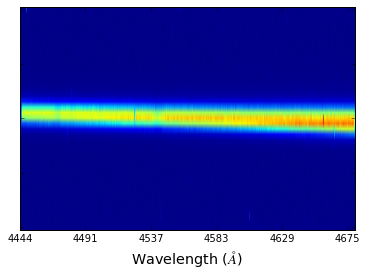

In [169]:
plt.imshow(obj_data, aspect='auto')
ax = plt.gca()
xt = ax.get_xticks()
ax.set_xticklabels([int(x) for x in ws(xt)])
plt.xlabel('Wavelength ($\AA$)', size='x-large')
ax.set_yticklabels([])
plt.savefig('spec2d.pdf')
plt.show()
#ax.set_yticklabels([])

In [163]:
# sum the spectra between two steps 
# The spectra could be traced for better results
# or it could extracted using more optimum methods

warr = ws(xarr)
flux = np.zeros_like(warr)
for i in range(18,25):
    f = np.interp(warr, wave_map[i], obj_data[i])
    flux += f

sky = np.zeros_like(warr)
for i in range(25,32):
    f = np.interp(warr, wave_map[i], obj_data[i])
    sky += f
    

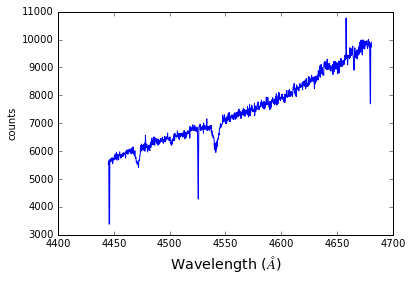

In [170]:
plt.plot(warr, flux - sky)
plt.xlabel('Wavelength ($\AA$)', size='x-large')
plt.ylabel('counts')
plt.savefig('spec1d.pdf')

plt.show()

In [156]:
#import pickle
#pickle.dump(iws, open('iws.db', 'wb'))
#iws = pickle.load(open('iws.db', 'rb'))

{5.5: <specreduce.WavelengthSolution.WavelengthSolution at 0x11d2f9780>,
 20.5: <specreduce.WavelengthSolution.WavelengthSolution at 0x117fdb438>,
 25.5: <specreduce.WavelengthSolution.WavelengthSolution at 0x112709630>}